In [1]:
# Importing Libraries

In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np

In [4]:
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}


def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

# Data

In [5]:

SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:

def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)


def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 
        
    return np.transpose(signals_data, (1, 2, 0))

In [7]:

def load_y(subset):
   
    filename = f'Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

In [8]:
def load_data():
   
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')
   

    return X_train, X_test, y_train, y_test

In [9]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [10]:
pip install tensorflow


In [11]:
import tensorflow as tf
tf.random.set_seed(42)

In [12]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.normalization import BatchNormalization

In [13]:
X_train, X_test, Y_train, Y_test = load_data()

In [14]:
X_test

array([[[ 1.165315e-02, -2.939904e-02,  1.068262e-01, ...,
          1.041216e+00, -2.697959e-01,  2.377977e-02],
        [ 1.310909e-02, -3.972867e-02,  1.524549e-01, ...,
          1.041803e+00, -2.800250e-01,  7.629271e-02],
        [ 1.126885e-02, -5.240586e-02,  2.168462e-01, ...,
          1.039086e+00, -2.926631e-01,  1.474754e-01],
        ...,
        [ 1.291511e-03,  1.173502e-02,  3.665587e-03, ...,
          9.930164e-01, -2.599865e-01,  1.443951e-01],
        [ 1.469997e-03,  9.517414e-03,  4.041945e-03, ...,
          9.932414e-01, -2.620643e-01,  1.447033e-01],
        [ 2.573841e-03,  7.305069e-03,  4.888436e-03, ...,
          9.943906e-01, -2.641348e-01,  1.454939e-01]],

       [[ 9.279629e-03,  6.650520e-03, -2.631933e-02, ...,
          9.991921e-01, -2.649349e-01,  1.256164e-01],
        [ 4.929711e-03,  1.864973e-02, -2.688753e-02, ...,
          9.946787e-01, -2.532142e-01,  1.256249e-01],
        [ 3.953596e-03,  1.553950e-02, -3.663861e-02, ...,
          9.93

In [15]:
X_test.shape

(2947, 128, 9)

In [17]:
print("Minimum value:",X_train.min())
print("Maximum value:",X_train.max())

Minimum value: -5.97433
Maximum value: 5.746062


In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 6

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


### MODEL 1

In [17]:
epochs = 3
batch_size = 32
n_hidden = 128
pv = 0.25

In [18]:
model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
model.add(BatchNormalization())
model.add(Dropout(pv))
model.add(Dense(n_classes, activation='sigmoid'))

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [20]:
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Epoch 1/3
230/230 [==============================] - 46s 76ms/step - loss: 1.0253 - accuracy: 0.5983 - val_loss: 0.8575 - val_accuracy: 0.6834
Epoch 2/3
230/230 [==============================] - 18s 77ms/step - loss: 0.3827 - accuracy: 0.8551 - val_loss: 0.4510 - val_accuracy: 0.8500
Epoch 3/3
230/230 [==============================] - 17s 75ms/step - loss: 0.2061 - accuracy: 0.9218 - val_loss: 0.3346 - val_accuracy: 0.8870


In [21]:
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 536        0         0        0                   0   
SITTING                  1      279       210        0                   0   
STANDING                 0       28       496        8                   0   
WALKING                  0        0         0      465                  16   
WALKING_DOWNSTAIRS       0        0         0        0                 420   
WALKING_UPSTAIRS         0        0         1       52                   0   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             1  
SITTING                            1  
STANDING                           0  
WALKING                           15  
WALKING_DOWNSTAIRS                 0  
WALKING_UPSTAIRS                 418  


In [22]:
score = model.evaluate(X_test, Y_test)

93/93 [==============================] - 2s 22ms/step - loss: 0.3346 - accuracy: 0.8870


In [23]:
score

[0.33464500308036804, 0.8870037198066711]

In [24]:
results=model.predict(X_test,batch_size=None,
    verbose=0,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False)


In [25]:
results

array([[2.5234821e-01, 2.4093658e-02, 2.6705950e-02, 7.3029935e-01,
        9.9559182e-01, 6.4745009e-02],
       [1.8497106e-01, 1.7208189e-02, 2.1590143e-02, 7.7318025e-01,
        9.9690425e-01, 4.5709282e-02],
       [1.9937444e-01, 1.7317295e-02, 2.0727068e-02, 7.5571334e-01,
        9.9676275e-01, 4.1507363e-02],
       ...,
       [5.1050884e-01, 9.9996603e-01, 6.0936624e-01, 4.9728155e-04,
        9.7952306e-02, 8.0423057e-03],
       [3.4943131e-01, 9.9987006e-01, 1.7835277e-01, 6.7496002e-03,
        1.1189270e-01, 1.9238502e-02],
       [4.0211412e-01, 9.9989522e-01, 1.5019405e-01, 3.0221790e-02,
        4.7803104e-02, 7.9401433e-02]], dtype=float32)

In [26]:
print("Predicted values || Actual values")
for i in range(0,len(results)):
    prediction = (np.argmax(results[i], axis=0))
    actual_val= (np.argmax(Y_test[i], axis=0))
    print(ACTIVITIES[prediction]+"         ||    "+ACTIVITIES[actual_val])

Predicted values || Actual values
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDI

STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITTING
SITTING         ||    SITT

In [27]:
#student_df = pd.DataFrame(students)
predict=[]
predit=pd.DataFrame(predict)
lp=[]
for i in range(0,len(results)):
    lp.append((ACTIVITIES[np.argmax(results[i], axis=0)]))
predict=pd.DataFrame(lp,columns=['ActivityName'])

    



In [28]:
from keras.models import model_from_json

In [29]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


LSTM Model2

stacking 2 LSTM 

In [30]:
epochs1 = 15
batch_size1= 32
n_hidden1 = 128
n_hidden2 =64
pv1 = 0.2
pv2 = 0.5

In [31]:
model1 = Sequential()
model1.add(LSTM(n_hidden1, return_sequences=True, input_shape=(timesteps, input_dim)))
model1.add(Dropout(pv1))
model1.add(LSTM(n_hidden2))
model1.add(Dropout(pv2))
model1.add(Dense(n_classes, activation='sigmoid'))

In [32]:
model1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [33]:
model1.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs1)

Epoch 1/15
230/230 [==============================] - 33s 132ms/step - loss: 1.1472 - accuracy: 0.5070 - val_loss: 0.7330 - val_accuracy: 0.6824
Epoch 2/15
230/230 [==============================] - 30s 130ms/step - loss: 0.5305 - accuracy: 0.8056 - val_loss: 0.5768 - val_accuracy: 0.8107
Epoch 3/15
230/230 [==============================] - 30s 132ms/step - loss: 0.2962 - accuracy: 0.9068 - val_loss: 0.2747 - val_accuracy: 0.8965
Epoch 4/15
230/230 [==============================] - 30s 131ms/step - loss: 0.2628 - accuracy: 0.9116 - val_loss: 0.5180 - val_accuracy: 0.8324
Epoch 5/15
230/230 [==============================] - 31s 133ms/step - loss: 0.1779 - accuracy: 0.9403 - val_loss: 0.5216 - val_accuracy: 0.8605
Epoch 6/15
230/230 [==============================] - 31s 134ms/step - loss: 0.1459 - accuracy: 0.9425 - val_loss: 0.3218 - val_accuracy: 0.9114
Epoch 7/15
230/230 [==============================] - 32s 137ms/step - loss: 0.1477 - accuracy: 0.9434 - val_loss: 0.3001 - val_ac

In [34]:
print(confusion_matrix(Y_test, model1.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  6      357       127        0                   0   
STANDING                 0       47       485        0                   0   
WALKING                  0        0         0      469                  25   
WALKING_DOWNSTAIRS       0        0         0        3                 416   
WALKING_UPSTAIRS         0        0         0       11                   1   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            1  
STANDING                           0  
WALKING                            2  
WALKING_DOWNSTAIRS                 1  
WALKING_UPSTAIRS                 459  


In [35]:
score1 = model1.evaluate(X_test, Y_test)

93/93 [==============================] - 5s 50ms/step - loss: 0.2942 - accuracy: 0.9240


In [36]:
score1

[0.29418501257896423, 0.9239904880523682]

In [37]:
results=model.predict(X_test,batch_size=None,
    verbose=0,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False)

In [38]:
print("Predicted values || Actual values")
for i in range(0,len(results)):
    prediction = (np.argmax(results[i], axis=0))
    actual_val= (np.argmax(Y_test[i], axis=0))
    print(ACTIVITIES[prediction]+"         ||    "+ACTIVITIES[actual_val])


Predicted values || Actual values
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDING         ||    STANDING
STANDI

LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
LAYING         ||    LAYING
WALKING         ||    WALKING
WALKING         ||    WALKING
WALKING         

In [39]:
type(actual_val)

numpy.int64

In [40]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [41]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


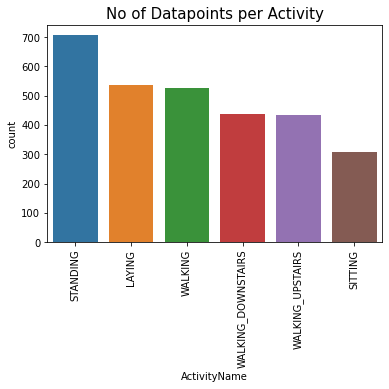

In [43]:
plt.title('No of Datapoints per Activity', fontsize=15)
sns.countplot(x=predict.ActivityName)
plt.xticks(rotation=90)
plt.show()